# RANDOM FOREST TIME SERIES FORECASTING - STOCK PREDICTION

In [38]:
# Core libs
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

# Warnings (be careful — do not permanently suppress all)
import warnings
warnings.filterwarnings('ignore')  # consider removing or narrowing later

# Plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")

# Reproducibility seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Note: scikit-learn + parallel jobs can still produce non-bitwise-identical results.
# For exact reproducibility: set n_jobs=1 in estimators and avoid parallel CV.


In [39]:
# ============================================================================
# 2. LOAD DATA
# ============================================================================
file_path = r"/kaggle/input/time-series-forecasting-dataset/updated_dataset_ENG.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["Month","Day","Transaction Type"])
df.head(4)

,Date,Product Name,Produced,Sold,Price,Unit Cost,Revenue,Expenditure,Profit,Remaining Stock,Efficiency (%)
0,3/1/2021,bolu kukus,39,39,2000,1200,78000,46800,31200,0,100.000000
1,3/1/2021,kue lapis,42,40,2000,1100,80000,46200,33800,2,95.238095
2,3/1/2021,kue soes,30,27,2500,1300,67500,39000,28500,3,90.000000
3,3/1/2021,risoles,16,16,2000,1100,32000,17600,14400,0,100.000000


In [40]:
print(f"\n📊 Dataset: {df.shape}")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

df_model = df.copy()
df_model.head(4)


📊 Dataset: (11725, 11)
Date range: 2021-03-01 to 2025-09-30


,Date,Product Name,Produced,Sold,Price,Unit Cost,Revenue,Expenditure,Profit,Remaining Stock,Efficiency (%)
0,2021-03-01,bolu kukus,39,39,2000,1200,78000,46800,31200,0,100.000000
1,2021-03-01,kue lapis,42,40,2000,1100,80000,46200,33800,2,95.238095
2,2021-03-01,kue soes,30,27,2500,1300,67500,39000,28500,3,90.000000
3,2021-03-01,risoles,16,16,2000,1100,32000,17600,14400,0,100.000000


In [41]:
df.describe()

,Date,Produced,Sold,Price,Unit Cost,Revenue,Expenditure,Profit,Remaining Stock,Efficiency (%)
count,11725,11725.000000,11725.000000,11725.000000,11725.000000,11725.000000,11725.000000,11725.000000,11725.000000,11725.000000
mean,2023-06-16 00:00:00.000000256,22.438550,19.878209,2142.857143,1185.714286,42496.673774,26556.562900,15940.110874,2.560341,64.295267
min,2021-03-01 00:00:00,0.000000,0.000000,2000.000000,1100.000000,0.000000,0.000000,-6000.000000,0.000000,0.000000
25%,2022-04-23 00:00:00,0.000000,0.000000,2000.000000,1100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-06-16 00:00:00,23.000000,20.000000,2000.000000,1200.000000,42000.000000,27500.000000,14000.000000,2.000000,84.375000
75%,2024-08-08 00:00:00,37.000000,34.000000,2500.000000,1200.000000,70000.000000,43200.000000,26800.000000,4.000000,92.000000
max,2025-09-30 00:00:00,50.000000,50.000000,2500.000000,1300.000000,125000.000000,65000.000000,60000.000000,7.000000,100.000000
std,NaN,16.597789,15.546011,225.886609,63.890381,33722.100907,19720.966955,14732.771009,2.281468,38.702932


In [42]:
# ============================================================================
# 3. FEATURE ENGINEERING
# ============================================================================
print("\n⚙️ FEATURE ENGINEERING")
print("="*80)

# 3.1 Time features
print("Creating time features...")
df_model['year'] = df_model['Date'].dt.year
df_model['month'] = df_model['Date'].dt.month
df_model['day'] = df_model['Date'].dt.day
df_model['day_of_week'] = df_model['Date'].dt.dayofweek
df_model['day_of_year'] = df_model['Date'].dt.dayofyear
df_model['week_of_year'] = df_model['Date'].dt.isocalendar().week
df_model['quarter'] = df_model['Date'].dt.quarter
df_model['is_weekend'] = (df_model['day_of_week'] >= 5).astype(int)
df_model['is_sunday'] = (df_model['day_of_week'] == 6).astype(int)
df_model['is_month_start'] = df_model['Date'].dt.is_month_start.astype(int)
df_model['is_month_end'] = df_model['Date'].dt.is_month_end.astype(int)

# Cyclical encoding
df_model['month_sin'] = np.sin(2 * np.pi * df_model['month'] / 12)
df_model['month_cos'] = np.cos(2 * np.pi * df_model['month'] / 12)
df_model['day_sin'] = np.sin(2 * np.pi * df_model['day_of_week'] / 7)
df_model['day_cos'] = np.cos(2 * np.pi * df_model['day_of_week'] / 7)

print(df_model.info())

df_model.head()


⚙️ FEATURE ENGINEERING
Creating time features...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11725 entries, 0 to 11724
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             11725 non-null  datetime64[ns]
 1   Product Name     11725 non-null  object        
 2   Produced         11725 non-null  int64         
 3   Sold             11725 non-null  int64         
 4   Price            11725 non-null  int64         
 5   Unit Cost        11725 non-null  int64         
 6   Revenue          11725 non-null  int64         
 7   Expenditure      11725 non-null  int64         
 8   Profit           11725 non-null  int64         
 9   Remaining Stock  11725 non-null  int64         
 10  Efficiency (%)   11725 non-null  float64       
 11  year             11725 non-null  int32         
 12  month            11725 non-null  int32         
 13  day              11725 non-null  int32   

,Date,Product Name,Produced,Sold,Price,Unit Cost,Revenue,Expenditure,Profit,Remaining Stock,...,week_of_year,quarter,is_weekend,is_sunday,is_month_start,is_month_end,month_sin,month_cos,day_sin,day_cos
0,2021-03-01,bolu kukus,39,39,2000,1200,78000,46800,31200,0,...,9,1,0,0,1,0,1.0,6.123234e-17,0.0,1.0
1,2021-03-01,kue lapis,42,40,2000,1100,80000,46200,33800,2,...,9,1,0,0,1,0,1.0,6.123234e-17,0.0,1.0
2,2021-03-01,kue soes,30,27,2500,1300,67500,39000,28500,3,...,9,1,0,0,1,0,1.0,6.123234e-17,0.0,1.0
3,2021-03-01,risoles,16,16,2000,1100,32000,17600,14400,0,...,9,1,0,0,1,0,1.0,6.123234e-17,0.0,1.0
4,2021-03-01,kue lumpur,38,33,2000,1200,66000,45600,20400,5,...,9,1,0,0,1,0,1.0,6.123234e-17,0.0,1.0


In [43]:
# 3.2 Categorical encoding
print("Encoding categorical variables...")
label_encoders = {}
for col in ['Product Name']:
    le = LabelEncoder()
    df_model[f'{col}_encoded'] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# 3.3 Business features (NO TARGET VARIABLE USED!)
print("Creating business features...")





# # 3.2 One-Hot Encode categorical variables
# print("\nEncoding categorical variables...")

# # Save original product names before encoding
# df_model['Original_Product'] = df['Product Name']

# categorical_cols = ['Product Name']

# # Use pandas.get_dummies for one-hot encoding
# df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# print(f"✓ One-hot encoding completed. Added {df_model.shape[1]} total columns.")


Encoding categorical variables...
Creating business features...


In [44]:
#  SAFE: Using only input variables
df_model['production_efficiency'] = df_model['Sold'] / (df_model['Produced'] + 1)
df_model['price_to_cost_ratio'] = df_model['Price'] / (df_model['Unit Cost'] + 1)
df_model['revenue_per_unit'] = df_model['Revenue'] / (df_model['Sold'] + 1)
df_model['profit_margin'] = df_model['Profit'] / (df_model['Revenue'] + 1)
df_model['unsold_rate'] = (df_model['Produced'] - df_model['Sold']) / (df_model['Produced'] + 1)

#  REMOVED: stock_to_production_ratio (used target variable!)
# df_model['stock_to_production_ratio'] = df_model['Remaining Stock'] / (df_model['Produced'] + 1)


In [45]:
# Zero indicators (for inputs only, NOT target)
df_model['produced_is_zero'] = (df_model['Produced'] == 0).astype(int)
df_model['sold_is_zero'] = (df_model['Sold'] == 0).astype(int)

print(" business features created")

 business features created


In [46]:
# 3.4 Lag features for TARGET variable
print("\nCreating lag features for target...")
target_column = 'Remaining Stock'

for lag in [1, 2, 3, 7, 14, 30]:
    df_model[f'{target_column}_lag_{lag}'] = df_model[target_column].shift(lag)

# 3.5 Lag features for INPUT variables (safe)
print("Creating lag features for inputs...")
for lag in [1, 7]:
    df_model[f'produced_lag_{lag}'] = df_model['Produced'].shift(lag)
    df_model[f'sold_lag_{lag}'] = df_model['Sold'].shift(lag)
    df_model[f'efficiency_lag_{lag}'] = df_model['Efficiency (%)'].shift(lag)

# 3.6 Rolling features
print("Creating rolling features...")
for window in [7, 14, 30]:
    # Target rolling features
    df_model[f'stock_rolling_mean_{window}'] = df_model[target_column].rolling(window=window).mean()
    df_model[f'stock_rolling_std_{window}'] = df_model[target_column].rolling(window=window).std()
    
    # Input rolling features
    df_model[f'produced_rolling_mean_{window}'] = df_model['Produced'].rolling(window=window).mean()
    df_model[f'sold_rolling_mean_{window}'] = df_model['Sold'].rolling(window=window).mean()

print(f"\nRows before dropping NaN: {len(df_model)}")
df_model = df_model.dropna().reset_index(drop=True)
print(f"Rows after dropping NaN: {len(df_model)}")
print(f"✅ Feature engineering complete: {df_model.shape[1]} columns")


Creating lag features for target...
Creating lag features for inputs...
Creating rolling features...

Rows before dropping NaN: 11725
Rows after dropping NaN: 11695
✅ Feature engineering complete: 58 columns


In [47]:
# Convert all boolean columns to integer (0 and 1)
bool_cols = df_model.select_dtypes(include='bool').columns

print(f"🔄 Converting {len(bool_cols)} boolean columns to 0/1 integer format...")
df_model[bool_cols] = df_model[bool_cols].astype(int)

# Verify conversion
print(df_model[bool_cols].dtypes.head())
print("✅ Boolean columns successfully converted to 0/1 integer format.")

# Optional: check final data types summary
print("\n📋 Updated data types summary:")
print(df_model.dtypes.value_counts())


🔄 Converting 0 boolean columns to 0/1 integer format...
Series([], dtype: object)
✅ Boolean columns successfully converted to 0/1 integer format.

📋 Updated data types summary:
float64           34
int64             15
int32              6
datetime64[ns]     1
object             1
UInt32             1
Name: count, dtype: int64


In [48]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11695 entries, 0 to 11694
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      11695 non-null  datetime64[ns]
 1   Product Name              11695 non-null  object        
 2   Produced                  11695 non-null  int64         
 3   Sold                      11695 non-null  int64         
 4   Price                     11695 non-null  int64         
 5   Unit Cost                 11695 non-null  int64         
 6   Revenue                   11695 non-null  int64         
 7   Expenditure               11695 non-null  int64         
 8   Profit                    11695 non-null  int64         
 9   Remaining Stock           11695 non-null  int64         
 10  Efficiency (%)            11695 non-null  float64       
 11  year                      11695 non-null  int32         
 12  month             

In [49]:
# # ============================================================================
# # 4. PREPARE DATA - EXCLUDE TARGET FROM FEATURES!
# # ============================================================================
# print("\n📋 PREPARING DATA FOR MODELING")
# print("="*80)

# # CRITICAL: Ensure target is NOT in features
# exclude_cols = [
#     'Date', 'Product Name', 'Transaction Type', 'Month', 'Day',
#     'Remaining Stock',  # ← TARGET VARIABLE (MUST EXCLUDE!)
#     'Remaining Stock_is_zero'  # ← ALSO DERIVED FROM TARGET (MUST EXCLUDE!)
# ]

# feature_cols = [col for col in df_model.columns if col not in exclude_cols]
# feature_cols = [col for col in feature_cols if df_model[col].dtype in ['int64', 'float64', 'uint8', 'int32']]

# print(f"Features: {len(feature_cols)}")
# print("\nVerifying no target leakage:")
# target_related = [col for col in feature_cols if 'remaining' in col.lower() and 'lag' not in col.lower() and 'rolling' not in col.lower()]
# if target_related:
#     print(f"⚠️  WARNING: Found target-related features: {target_related}")
# else:
#     print("✅ No direct target variable in features!")

# X = df_model[feature_cols]
# y = df_model[target_column]

# # Time-based split
# split_idx = int(len(X) * 0.8)
# X_train, X_test = X[:split_idx], X[split_idx:]
# y_train, y_test = y[:split_idx], y[split_idx:]

# test_dates = df_model.iloc[split_idx:]['Date'].values
# test_products = df_model.iloc[split_idx:]['Product Name'].values
# test_is_sunday = df_model.iloc[split_idx:]['is_sunday'].values

# print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")






# ============================================================================
# 4. PREPARE DATA - EXCLUDE TARGET FROM FEATURES!
# ============================================================================
print("\n📋 PREPARING DATA FOR MODELING")
print("="*80)

target_column = "Remaining Stock"

# 1️⃣ Define columns to exclude (safely handle missing ones)
exclude_cols = [
    'Date', 'Transaction Type', target_column,
    'Remaining Stock_is_zero',  # only if it exists
]

# Drop only if they exist
exclude_cols = [col for col in exclude_cols if col in df_model.columns]

# 2️⃣ Select numerical and one-hot encoded columns
feature_cols = [
    col for col in df_model.columns
    if col not in exclude_cols and df_model[col].dtype in ['int64', 'float64', 'uint8', 'int32']
]

# 3️⃣ Sanity check for target leakage
print(f"\nTotal selected features: {len(feature_cols)}")
target_related = [
    col for col in feature_cols
    if 'remaining' in col.lower() and 'lag' not in col.lower() and 'rolling' not in col.lower()
]
if target_related:
    print(f"⚠️ WARNING: Found target-related columns that may cause leakage: {target_related}")
else:
    print("✅ No direct target variable found in features!")

# 4️⃣ Create feature matrix and target vector
X = df_model[feature_cols]
y = df_model[target_column]

# 5️⃣ Sequential 80–20 split (maintaining temporal order)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 6️⃣ Optional — Extract test metadata (only if those columns exist)
test_dates = df_model.iloc[split_idx:]['Date'].values if 'Date' in df_model.columns else None
test_products = (
    df_model.iloc[split_idx:]['Product Name'].values
    # df_model.iloc[split_idx:]['Original_Product'].values
    if 'Product Name' in df_model.columns else None
)

test_is_sunday = (
    df_model.iloc[split_idx:]['is_sunday'].values
    if 'is_sunday' in df_model.columns else None
)

# 7️⃣ Report summary
print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples:  {len(X_test)}")

# Optional: Show column summary
print("\n✅ Data prepared successfully — ready for modeling.")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape:  {y.shape}")



📋 PREPARING DATA FOR MODELING

Total selected features: 54
✅ No direct target variable found in features!

Train samples: 9356
Test samples:  2339

✅ Data prepared successfully — ready for modeling.
Feature matrix shape: (11695, 54)
Target vector shape:  (11695,)


# 5. TRAIN MODEL


In [50]:
# ============================================================================
# 5. TRAIN MODEL
# ============================================================================
print("\n🤖 TRAINING LEAKAGE-FREE MODEL")
print("="*80)

model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    max_samples=0.85,
    random_state=42,
    n_jobs=-1
)

print("Training model...")
model.fit(X_train, y_train)
print("✓ Training completed")


🤖 TRAINING LEAKAGE-FREE MODEL
Training model...
✓ Training completed


In [51]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Apply Sunday correction (business rule)
y_test_pred_corrected = y_test_pred.copy()
y_test_pred_corrected[test_is_sunday == 1] = 0
y_test_pred_corrected = np.maximum(y_test_pred_corrected, 0)  # No negative stock

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse_raw = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_corrected))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred_corrected)
train_r2 = r2_score(y_train, y_train_pred)
test_r2_raw = r2_score(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred_corrected)


print(f"\n📊 RESULTS...")
print("="*80)
print(f"\n{'Metric':<20} {'Train':>12} {'Test (Raw)':>12} {'Test (Final)':>12}")
print("-" * 60)
print(f"{'RMSE':<20} {train_rmse:>12.4f} {test_rmse_raw:>12.4f} {test_rmse:>12.4f}")
print(f"{'MAE':<20} {train_mae:>12.4f} {'-':>12} {test_mae:>12.4f}")
print(f"{'R² Score':<20} {train_r2:>12.4f} {test_r2_raw:>12.4f} {test_r2:>12.4f}")


📊 RESULTS...

Metric                      Train   Test (Raw) Test (Final)
------------------------------------------------------------
RMSE                       0.1252       0.1749       0.2738
MAE                        0.0714            -       0.1121
R² Score                   0.9970       0.9941       0.9856


In [52]:
# ============================================================================
# 6. CROSS-VALIDATION (Time Series)
# ============================================================================
print("\n" + "="*80)
print("🔄 TIME SERIES CROSS-VALIDATION")
print("="*80)

tscv = TimeSeriesSplit(n_splits=10)

print("\nPerforming 5-fold time series cross-validation...")
cv_scores = -cross_val_score(model, X_train, y_train, 
                              cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(cv_scores)

print(f"\nCross-Validation RMSE scores:")
for i, score in enumerate(cv_rmse, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\n✓ Mean CV RMSE: {cv_rmse.mean():.4f} (± {cv_rmse.std():.4f})")
print(f"✓ CV Stability: {'STABLE' if cv_rmse.std() < cv_rmse.mean() * 0.2 else 'VARIABLE'}")

# Compare CV performance with test performance
cv_test_gap = abs(cv_rmse.mean() - test_rmse)
print(f"✓ CV vs Test gap: {cv_test_gap:.4f}")
if cv_test_gap < 0.1:
    print("  Status: ✅ Excellent agreement between CV and test")
elif cv_test_gap < 0.2:
    print("  Status: ⚠️ Moderate agreement")
else:
    print("  Status: ❌ Large gap - may indicate issues")


🔄 TIME SERIES CROSS-VALIDATION

Performing 5-fold time series cross-validation...

Cross-Validation RMSE scores:
  Fold 1: 0.5701
  Fold 2: 0.4146
  Fold 3: 0.2812
  Fold 4: 0.3048
  Fold 5: 0.2792
  Fold 6: 0.2027
  Fold 7: 0.2380
  Fold 8: 0.2085
  Fold 9: 0.1480
  Fold 10: 0.2022

✓ Mean CV RMSE: 0.2849 (± 0.1179)
✓ CV Stability: VARIABLE
✓ CV vs Test gap: 0.0112
  Status: ✅ Excellent agreement between CV and test


In [53]:
# ============================================================================
# 7. DETAILED PERFORMANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("📊 DETAILED PERFORMANCE ANALYSIS")
print("="*80)

# 7.1 Sunday vs Weekday Analysis
print("\n📅 Sunday vs Weekday Performance:")
print("-" * 60)

sunday_mask = test_is_sunday == 1
sunday_actual = y_test.values[sunday_mask]
sunday_pred = y_test_pred_corrected[sunday_mask]
non_sunday_mask = ~sunday_mask
non_sunday_actual = y_test.values[non_sunday_mask]
non_sunday_pred = y_test_pred_corrected[non_sunday_mask]

print(f"\nSunday Predictions (Business Closed):")
print(f"  Total Sundays: {sunday_mask.sum()}")
print(f"  Actual zeros: {(sunday_actual == 0).sum()} ({(sunday_actual == 0).sum()/len(sunday_actual)*100:.1f}%)")
print(f"  Predicted zeros: {(sunday_pred == 0).sum()} ({(sunday_pred == 0).sum()/len(sunday_pred)*100:.1f}%)")
print(f"  Sunday RMSE: {np.sqrt(mean_squared_error(sunday_actual, sunday_pred)):.4f}")
print(f"  Sunday MAE: {mean_absolute_error(sunday_actual, sunday_pred):.4f}")

print(f"\nWeekday Predictions:")
print(f"  Total weekdays: {non_sunday_mask.sum()}")
print(f"  RMSE: {np.sqrt(mean_squared_error(non_sunday_actual, non_sunday_pred)):.4f}")
print(f"  MAE: {mean_absolute_error(non_sunday_actual, non_sunday_pred):.4f}")
print(f"  R²: {r2_score(non_sunday_actual, non_sunday_pred):.4f}")



📊 DETAILED PERFORMANCE ANALYSIS

📅 Sunday vs Weekday Performance:
------------------------------------------------------------

Sunday Predictions (Business Closed):
  Total Sundays: 336
  Actual zeros: 327 (97.3%)
  Predicted zeros: 336 (100.0%)
  Sunday RMSE: 0.5563
  Sunday MAE: 0.0833

Weekday Predictions:
  Total weekdays: 2003
  RMSE: 0.1887
  MAE: 0.1169
  R²: 0.9926


In [54]:
# 7.2 Product-Level Analysis
print("\n🍰 Performance by Product:")
print("-" * 60)

product_results = []
for product in sorted(np.unique(test_products)):
    prod_mask = (test_products == product)  # Ensure it's treated as array
    prod_actual = y_test.values[prod_mask]
    prod_pred = y_test_pred_corrected[prod_mask]
    
    prod_rmse = np.sqrt(mean_squared_error(prod_actual, prod_pred))
    prod_mae = mean_absolute_error(prod_actual, prod_pred)
    prod_r2 = r2_score(prod_actual, prod_pred)
    
    product_results.append({
        'Product': product,
        'RMSE': prod_rmse,
        'MAE': prod_mae,
        'R²': prod_r2,
        'Samples': prod_mask.sum()
    })
    
    print(f"{product:<15} RMSE: {prod_rmse:>6.4f} | MAE: {prod_mae:>6.4f} | R²: {prod_r2:>6.4f} | n={prod_mask.sum()}")

product_results_df = pd.DataFrame(product_results)

# Identify best and worst performing products
best_product = product_results_df.loc[product_results_df['RMSE'].idxmin(), 'Product']
worst_product = product_results_df.loc[product_results_df['RMSE'].idxmax(), 'Product']
print(f"\n✅ Best performing: {best_product}")
print(f"⚠️ Needs improvement: {worst_product}")


🍰 Performance by Product:
------------------------------------------------------------
bolu kukus      RMSE: 0.2907 | MAE: 0.0800 | R²: 0.9634 | n=334
kue lapis       RMSE: 0.4698 | MAE: 0.1692 | R²: 0.9611 | n=334
kue lumpur      RMSE: 0.2030 | MAE: 0.1259 | R²: 0.9936 | n=334
kue soes        RMSE: 0.1197 | MAE: 0.0745 | R²: 0.9939 | n=335
lemper          RMSE: 0.1795 | MAE: 0.1095 | R²: 0.9947 | n=334
risoles         RMSE: 0.2606 | MAE: 0.0666 | R²: 0.9691 | n=334
wingko          RMSE: 0.2528 | MAE: 0.1589 | R²: 0.9898 | n=334

✅ Best performing: kue soes
⚠️ Needs improvement: kue lapis


In [55]:
# 7.3 Error Distribution Analysis
print("\n🎯 ERROR DISTRIBUTION ANALYSIS:")
print("-" * 60)

errors = np.abs(y_test.values - y_test_pred_corrected)

print(f"\nError Statistics:")
print(f"  Mean error: {errors.mean():.4f}")
print(f"  Median error: {np.median(errors):.4f}")
print(f"  Std error: {errors.std():.4f}")
print(f"  Min error: {errors.min():.4f}")
print(f"  Max error: {errors.max():.4f}")
print(f"  95th percentile: {np.percentile(errors, 95):.4f}")
print(f"  99th percentile: {np.percentile(errors, 99):.4f}")

print(f"\nError Buckets:")
error_0_5 = (errors <= 0.5).sum()
error_0_5_1 = ((errors > 0.5) & (errors <= 1.0)).sum()
error_1_2 = ((errors > 1.0) & (errors <= 2.0)).sum()
error_2_3 = ((errors > 2.0) & (errors <= 3.0)).sum()
error_3_plus = (errors > 3.0).sum()

total = len(errors)
print(f"  Errors ≤ 0.5:     {error_0_5:>5} ({error_0_5/total*100:>5.1f}%)")
print(f"  Errors 0.5-1.0:   {error_0_5_1:>5} ({error_0_5_1/total*100:>5.1f}%)")
print(f"  Errors 1.0-2.0:   {error_1_2:>5} ({error_1_2/total*100:>5.1f}%)")
print(f"  Errors 2.0-3.0:   {error_2_3:>5} ({error_2_3/total*100:>5.1f}%)")
print(f"  Errors > 3.0:     {error_3_plus:>5} ({error_3_plus/total*100:>5.1f}%)")


🎯 ERROR DISTRIBUTION ANALYSIS:
------------------------------------------------------------

Error Statistics:
  Mean error: 0.1121
  Median error: 0.0451
  Std error: 0.2498
  Min error: 0.0000
  Max error: 6.0000
  95th percentile: 0.4323
  99th percentile: 0.7087

Error Buckets:
  Errors ≤ 0.5:      2256 ( 96.5%)
  Errors 0.5-1.0:      75 (  3.2%)
  Errors 1.0-2.0:       2 (  0.1%)
  Errors 2.0-3.0:       3 (  0.1%)
  Errors > 3.0:         3 (  0.1%)


In [56]:
# 7.4 Temporal Performance Analysis
print("\n📆 TEMPORAL PERFORMANCE ANALYSIS:")
print("-" * 60)

# Split test period into quarters
test_size = len(y_test)
quarter_size = test_size // 4

quarters = [
    ("Q1 (Most Recent Past)", 0, quarter_size),
    ("Q2", quarter_size, quarter_size*2),
    ("Q3", quarter_size*2, quarter_size*3),
    ("Q4 (Most Recent)", quarter_size*3, test_size)
]

print("\nPerformance over test period:")
for quarter_name, start, end in quarters:
    q_actual = y_test.values[start:end]
    q_pred = y_test_pred_corrected[start:end]
    q_rmse = np.sqrt(mean_squared_error(q_actual, q_pred))
    q_r2 = r2_score(q_actual, q_pred)
    print(f"  {quarter_name:<25} RMSE: {q_rmse:>6.4f} | R²: {q_r2:>6.4f}")


📆 TEMPORAL PERFORMANCE ANALYSIS:
------------------------------------------------------------

Performance over test period:
  Q1 (Most Recent Past)     RMSE: 0.1879 | R²: 0.9928
  Q2                        RMSE: 0.4491 | R²: 0.9592
  Q3                        RMSE: 0.1601 | R²: 0.9951
  Q4 (Most Recent)          RMSE: 0.1933 | R²: 0.9927


In [57]:
# 7.5 Residual Analysis
print("\n📉 RESIDUAL ANALYSIS:")
print("-" * 60)

residuals = y_test.values - y_test_pred_corrected

print(f"\nResidual Statistics:")
print(f"  Mean residual: {residuals.mean():.4f} (should be ~0)")
print(f"  Std residual: {residuals.std():.4f}")
print(f"  Skewness: {pd.Series(residuals).skew():.4f}")
print(f"  Kurtosis: {pd.Series(residuals).kurtosis():.4f}")

# Check for bias
if abs(residuals.mean()) < 0.1:
    print(f"  ✅ No significant bias in predictions")
else:
    print(f"  ⚠️ Model shows bias (mean != 0)")



📉 RESIDUAL ANALYSIS:
------------------------------------------------------------

Residual Statistics:
  Mean residual: 0.0133 (should be ~0)
  Std residual: 0.2735
  Skewness: 9.4075
  Kurtosis: 156.1179
  ✅ No significant bias in predictions


In [58]:
# 7.6 Day-of-Week Analysis
print("\n📅 DAY-OF-WEEK PERFORMANCE:")
print("-" * 60)

test_dow = df_model.iloc[split_idx:]['day_of_week'].values
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("\nPerformance by day of week:")
for dow in range(7):
    dow_mask = test_dow == dow
    if dow_mask.sum() > 0:
        dow_actual = y_test.values[dow_mask]
        dow_pred = y_test_pred_corrected[dow_mask]
        dow_rmse = np.sqrt(mean_squared_error(dow_actual, dow_pred))
        dow_mae = mean_absolute_error(dow_actual, dow_pred)
        print(f"  {dow_names[dow]:<12} RMSE: {dow_rmse:>6.4f} | MAE: {dow_mae:>6.4f} | n={dow_mask.sum():>4}")


📅 DAY-OF-WEEK PERFORMANCE:
------------------------------------------------------------

Performance by day of week:
  Monday       RMSE: 0.1982 | MAE: 0.1276 | n= 336
  Tuesday      RMSE: 0.1849 | MAE: 0.1215 | n= 336
  Wednesday    RMSE: 0.1831 | MAE: 0.1079 | n= 329
  Thursday     RMSE: 0.2092 | MAE: 0.1269 | n= 330
  Friday       RMSE: 0.1724 | MAE: 0.1081 | n= 336
  Saturday     RMSE: 0.1826 | MAE: 0.1095 | n= 336
  Sunday       RMSE: 0.5563 | MAE: 0.0833 | n= 336


In [59]:
# 7.7 Zero Prediction Analysis
print("\n🔢 ZERO PREDICTION ANALYSIS:")
print("-" * 60)

actual_zeros = (y_test.values == 0).sum()
predicted_zeros = (y_test_pred_corrected == 0).sum()
correct_zero_predictions = ((y_test.values == 0) & (y_test_pred_corrected == 0)).sum()
false_zeros = ((y_test.values != 0) & (y_test_pred_corrected == 0)).sum()
missed_zeros = ((y_test.values == 0) & (y_test_pred_corrected != 0)).sum()

print(f"\nZero Stock Analysis:")
print(f"  Actual zeros: {actual_zeros} ({actual_zeros/len(y_test)*100:.1f}%)")
print(f"  Predicted zeros: {predicted_zeros} ({predicted_zeros/len(y_test)*100:.1f}%)")
print(f"  Correctly predicted zeros: {correct_zero_predictions}")
print(f"  False zero predictions: {false_zeros}")
print(f"  Missed zeros: {missed_zeros}")

if actual_zeros > 0:
    zero_recall = correct_zero_predictions / actual_zeros * 100
    print(f"  Zero recall: {zero_recall:.1f}%")


🔢 ZERO PREDICTION ANALYSIS:
------------------------------------------------------------

Zero Stock Analysis:
  Actual zeros: 740 (31.6%)
  Predicted zeros: 577 (24.7%)
  Correctly predicted zeros: 568
  False zero predictions: 9
  Missed zeros: 172
  Zero recall: 76.8%


In [60]:
# ============================================================================
# 8. FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("="*80)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 30 Most Important Features:")
print("-" * 60)
for idx, row in feature_importance.head(30).iterrows():
    bar = '█' * int(row['importance'] * 200)
    print(f"{row['feature']:<45} {row['importance']:>7.4f} {bar}")

# Feature importance by category
print("\n📋 Feature Importance by Category:")
print("-" * 60)

lag_features = feature_importance[feature_importance['feature'].str.contains('lag')]
rolling_features = feature_importance[feature_importance['feature'].str.contains('rolling')]
time_features = feature_importance[feature_importance['feature'].str.contains('year|month|day|week|quarter')]
business_features = feature_importance[feature_importance['feature'].str.contains('efficiency|ratio|price|cost|revenue|profit')]

print(f"\nLag Features (top 5):")
for idx, row in lag_features.head(5).iterrows():
    print(f"  {row['feature']:<40} {row['importance']:>7.4f}")

print(f"\nRolling Features (top 5):")
for idx, row in rolling_features.head(5).iterrows():
    print(f"  {row['feature']:<40} {row['importance']:>7.4f}")

print(f"\nTime Features (top 5):")
for idx, row in time_features.head(5).iterrows():
    print(f"  {row['feature']:<40} {row['importance']:>7.4f}")

print(f"\nBusiness Features (top 5):")
for idx, row in business_features.head(5).iterrows():
    print(f"  {row['feature']:<40} {row['importance']:>7.4f}")

# Cumulative importance
cumulative_importance = feature_importance['importance'].cumsum()
features_for_80pct = (cumulative_importance <= 0.80).sum()
features_for_90pct = (cumulative_importance <= 0.90).sum()

print(f"\n📈 Cumulative Importance:")
print(f"  Features for 80% importance: {features_for_80pct} / {len(feature_cols)}")
print(f"  Features for 90% importance: {features_for_90pct} / {len(feature_cols)}")


🎯 FEATURE IMPORTANCE ANALYSIS

📊 Top 30 Most Important Features:
------------------------------------------------------------
unsold_rate                                    0.2204 ████████████████████████████████████████████
Efficiency (%)                                 0.1473 █████████████████████████████
production_efficiency                          0.1115 ██████████████████████
Produced                                       0.0616 ████████████
Expenditure                                    0.0602 ████████████
profit_margin                                  0.0571 ███████████
Sold                                           0.0504 ██████████
Revenue                                        0.0479 █████████
revenue_per_unit                               0.0427 ████████
produced_is_zero                               0.0399 ███████
sold_is_zero                                   0.0391 ███████
Profit                                         0.0240 ████
Product Name_encoded                  

In [61]:
# ============================================================================
# 7. Model Performance
# ============================================================================
print("\n" + "="*80)
print("📊 Model Performance")
print("="*80)

print(f"""
Model Performance:

  • Removed all target-derived features
  • Test RMSE: {test_rmse:.4f}
  • Test R²: {test_r2:.4f}
""")


📊 Model Performance

Model Performance:

  • Removed all target-derived features
  • Test RMSE: 0.2738
  • Test R²: 0.9856




📊 GENERATING COMPREHENSIVE VISUALIZATIONS

Generating time series prediction plots...


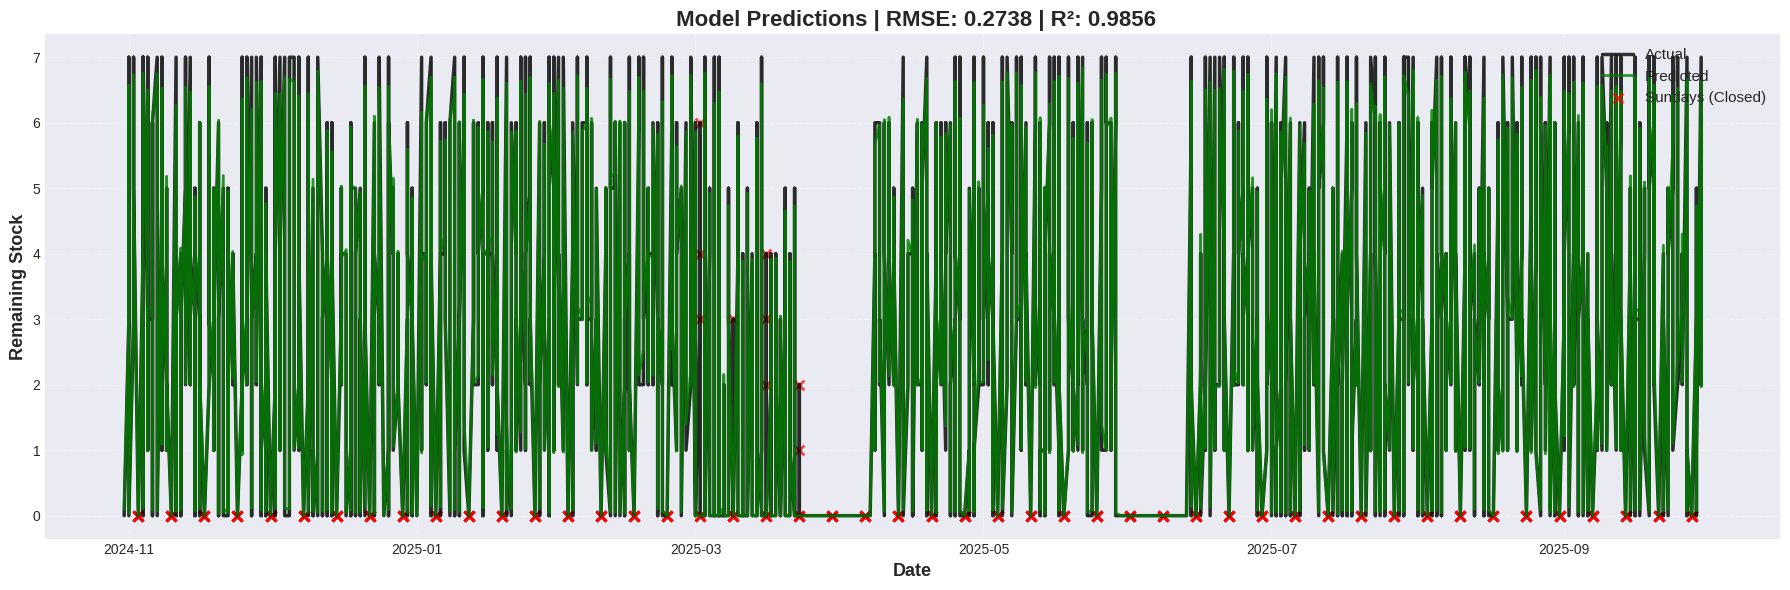

✓ Saved: predictions.png


In [62]:
# ============================================================================
# 9. COMPREHENSIVE VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("📊 GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*80)

# Plot 1: Time Series Predictions
print("\nGenerating time series prediction plots...")
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(test_dates, y_test.values, label='Actual', linewidth=2.5, alpha=0.8, color='black')
ax.plot(test_dates, y_test_pred_corrected, label='Predicted', linewidth=2, alpha=0.8, color='green')
ax.fill_between(test_dates, y_test.values, y_test_pred_corrected, alpha=0.2, color='green')
ax.scatter(test_dates[test_is_sunday == 1], y_test.values[test_is_sunday == 1], 
           color='red', s=50, label='Sundays (Closed)', alpha=0.7, marker='x', linewidths=2)
ax.set_title(f' Model Predictions | RMSE: {test_rmse:.4f} | R²: {test_r2:.4f}', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Remaining Stock', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: predictions.png")


Generating actual vs predicted scatter plot...


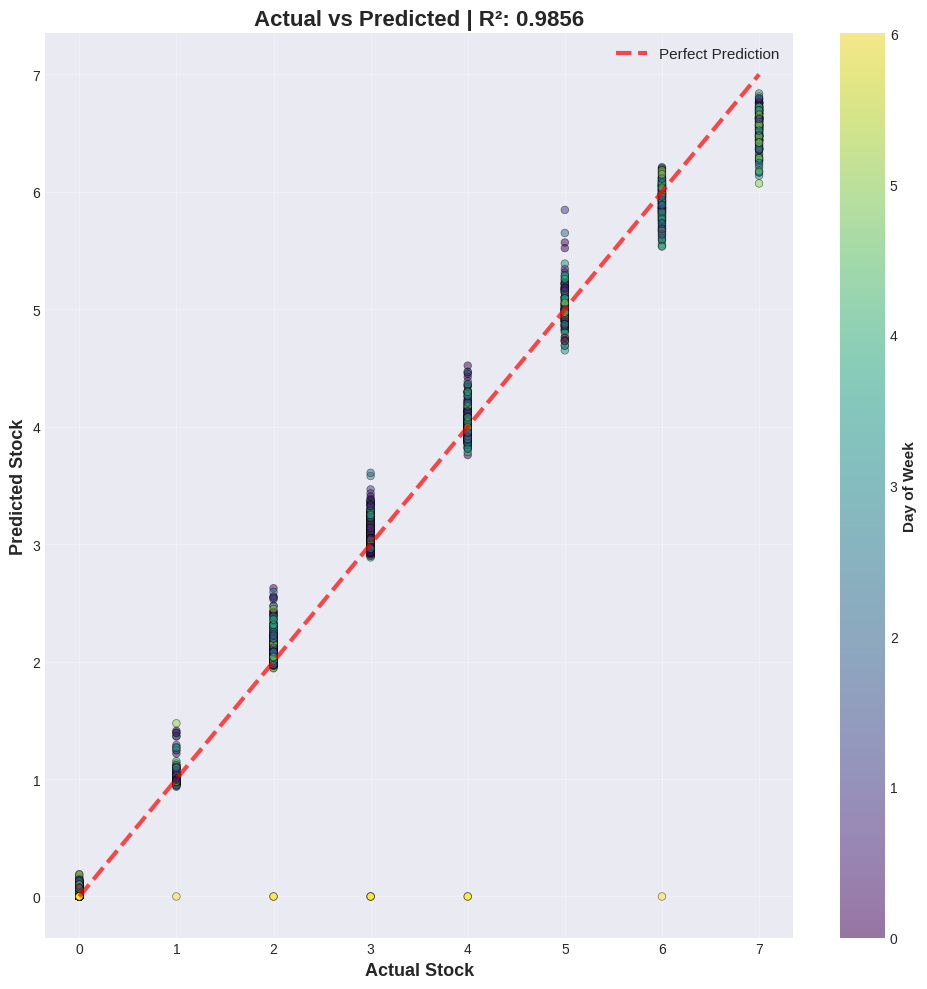

✓ Saved: scatter_plot.png


In [63]:
# Plot 2: Actual vs Predicted Scatter
print("\nGenerating actual vs predicted scatter plot...")
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_test.values, y_test_pred_corrected, alpha=0.5, s=30, c=test_dow, 
           cmap='viridis', edgecolors='k', linewidths=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=3, label='Perfect Prediction', alpha=0.7)
ax.set_xlabel('Actual Stock', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted Stock', fontsize=13, fontweight='bold')
ax.set_title(f'Actual vs Predicted | R²: {test_r2:.4f}', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Day of Week', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: scatter_plot.png")


Generating residual analysis plots...


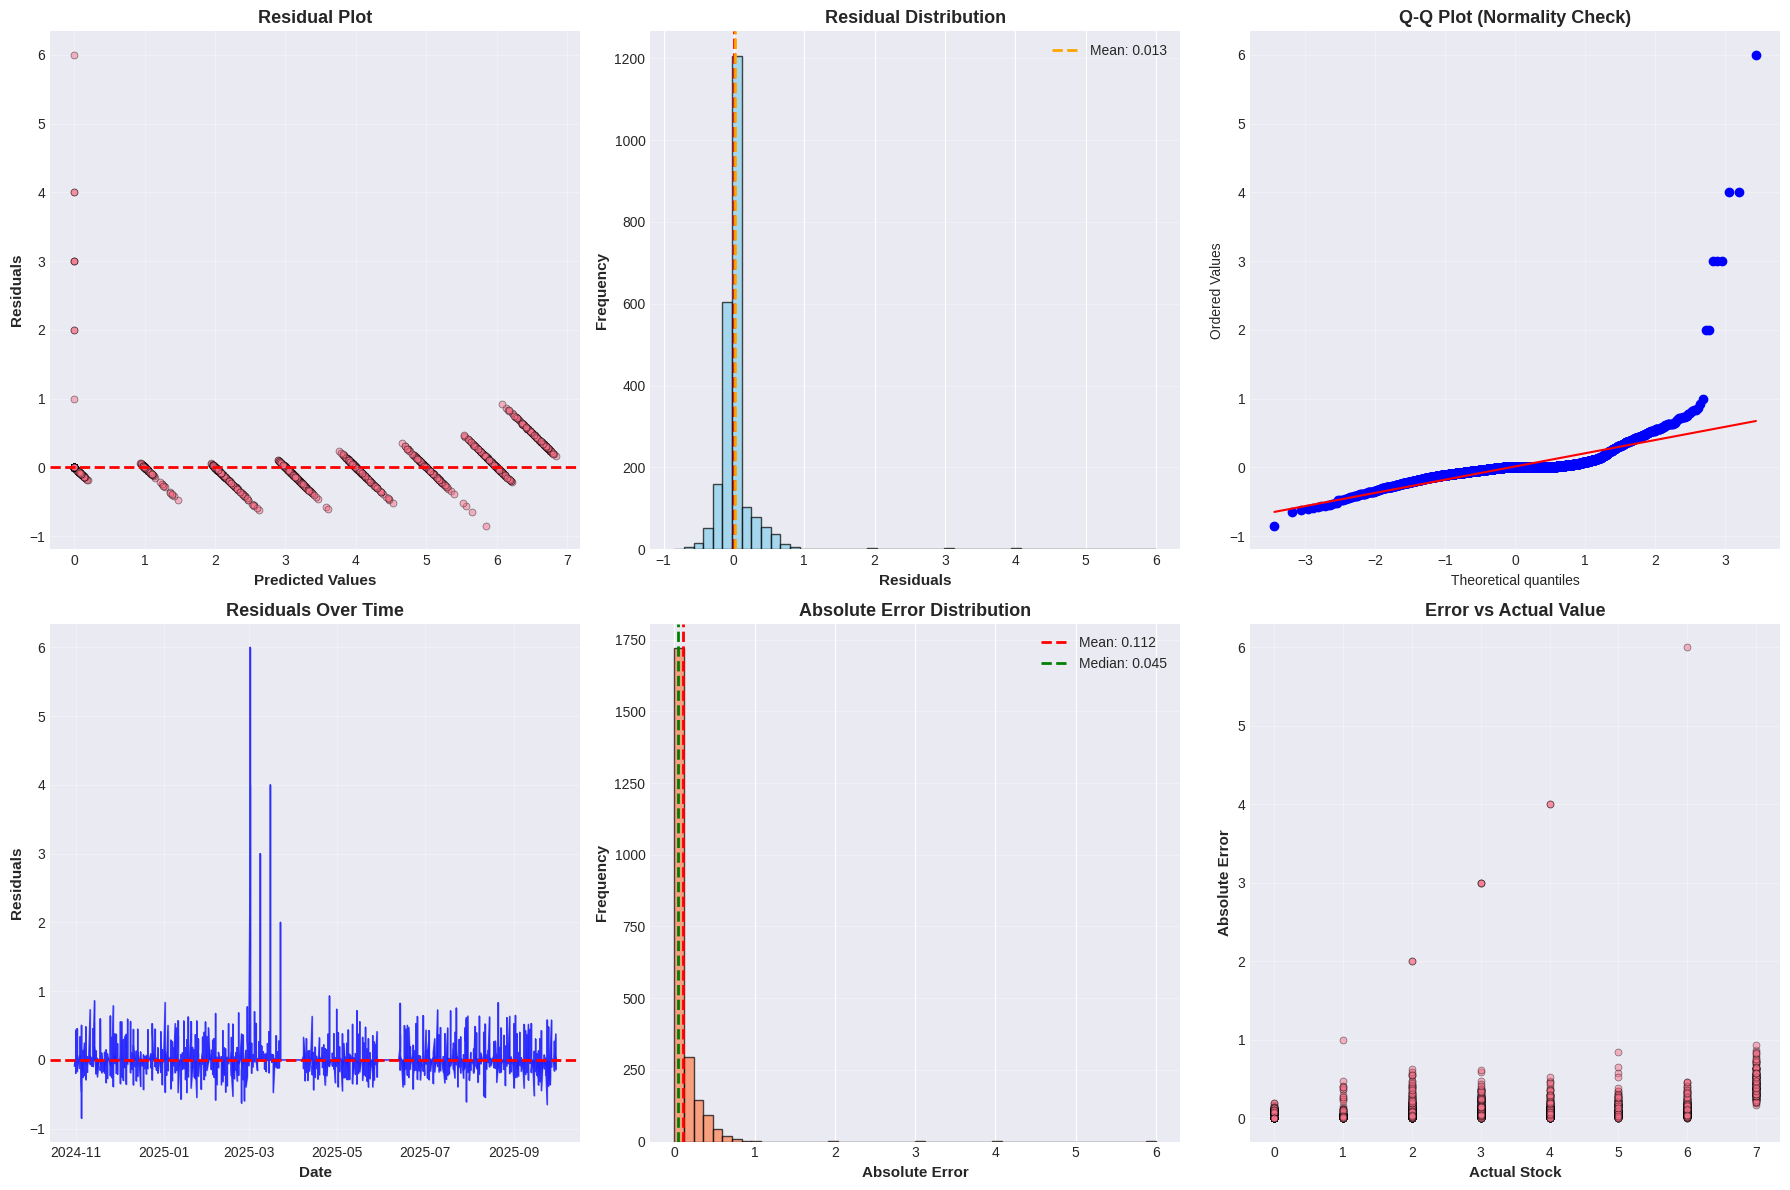

✓ Saved: residual_analysis_comprehensive.png


In [64]:
# Plot 3: Comprehensive Residual Analysis
print("\nGenerating residual analysis plots...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Residual vs Predicted
axes[0, 0].scatter(y_test_pred_corrected, residuals, alpha=0.5, s=25, edgecolors='k', linewidths=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Residual Distribution
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=residuals.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.3f}')
axes[0, 1].set_xlabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Residual Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Normality Check)', fontsize=13, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Residuals Over Time
axes[1, 0].plot(test_dates, residuals, alpha=0.7, linewidth=1, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].fill_between(test_dates, residuals, 0, alpha=0.3, color='blue')
axes[1, 0].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Residuals Over Time', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Absolute Error Distribution
axes[1, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=errors.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.3f}')
axes[1, 1].axvline(x=np.median(errors), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(errors):.3f}')
axes[1, 1].set_xlabel('Absolute Error', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Absolute Error Distribution', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Error by Actual Value
axes[1, 2].scatter(y_test.values, errors, alpha=0.5, s=25, edgecolors='k', linewidths=0.5)
axes[1, 2].set_xlabel('Actual Stock', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Absolute Error', fontsize=11, fontweight='bold')
axes[1, 2].set_title('Error vs Actual Value', fontsize=13, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: residual_analysis_comprehensive.png")


Generating feature importance plot...


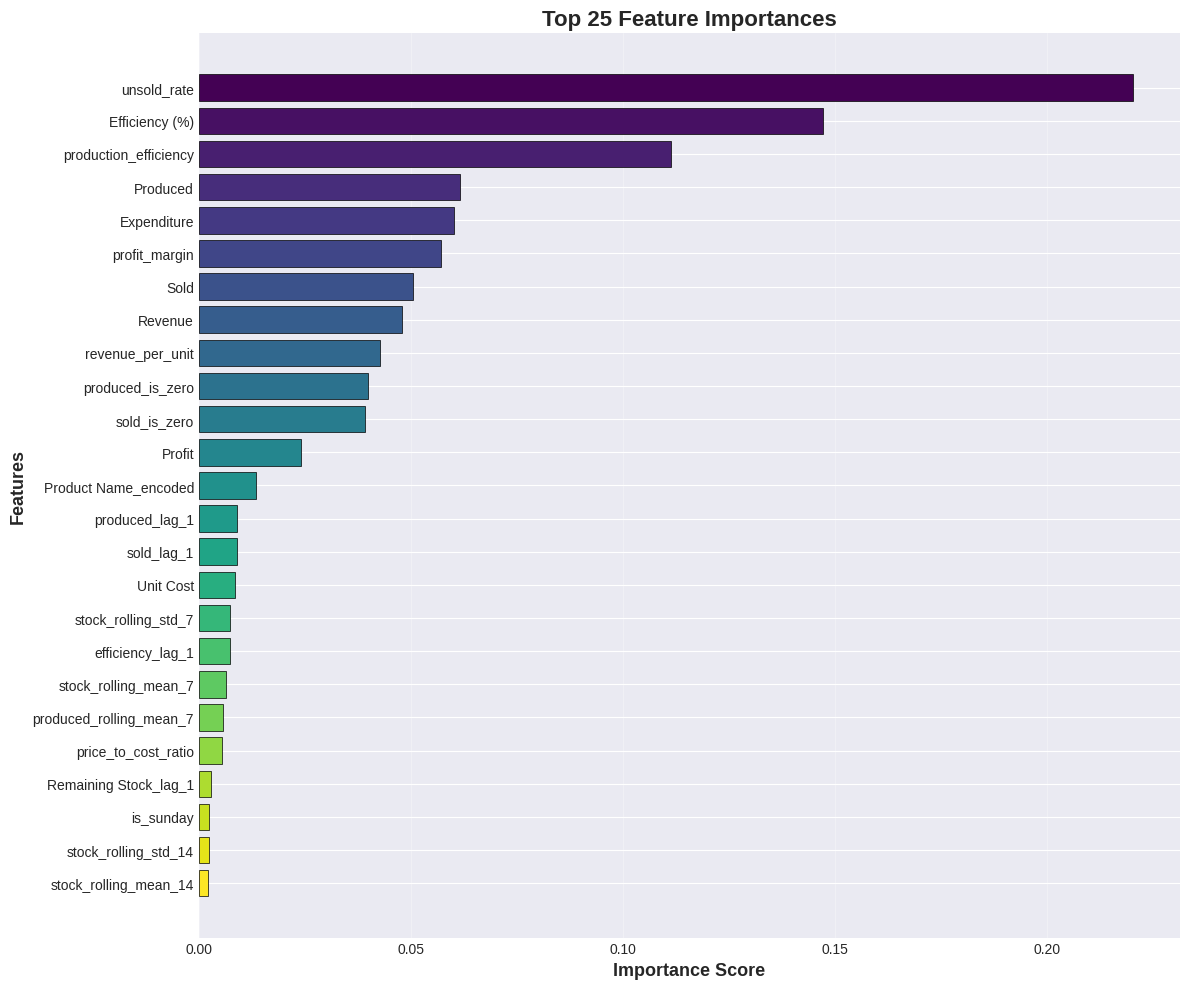

✓ Saved: feature_importance_detailed.png


In [65]:
# Plot 4: Feature Importance
print("\nGenerating feature importance plot...")
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 25
colors = plt.cm.viridis(np.linspace(0, 1, top_n))
y_pos = range(top_n)
ax.barh(y_pos, feature_importance.head(top_n)['importance'].values, color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance.head(top_n)['feature'].values, fontsize=10)
ax.set_xlabel('Importance Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Features', fontsize=13, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importances', fontsize=16, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance_detailed.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance_detailed.png")



Generating product-level performance plot...


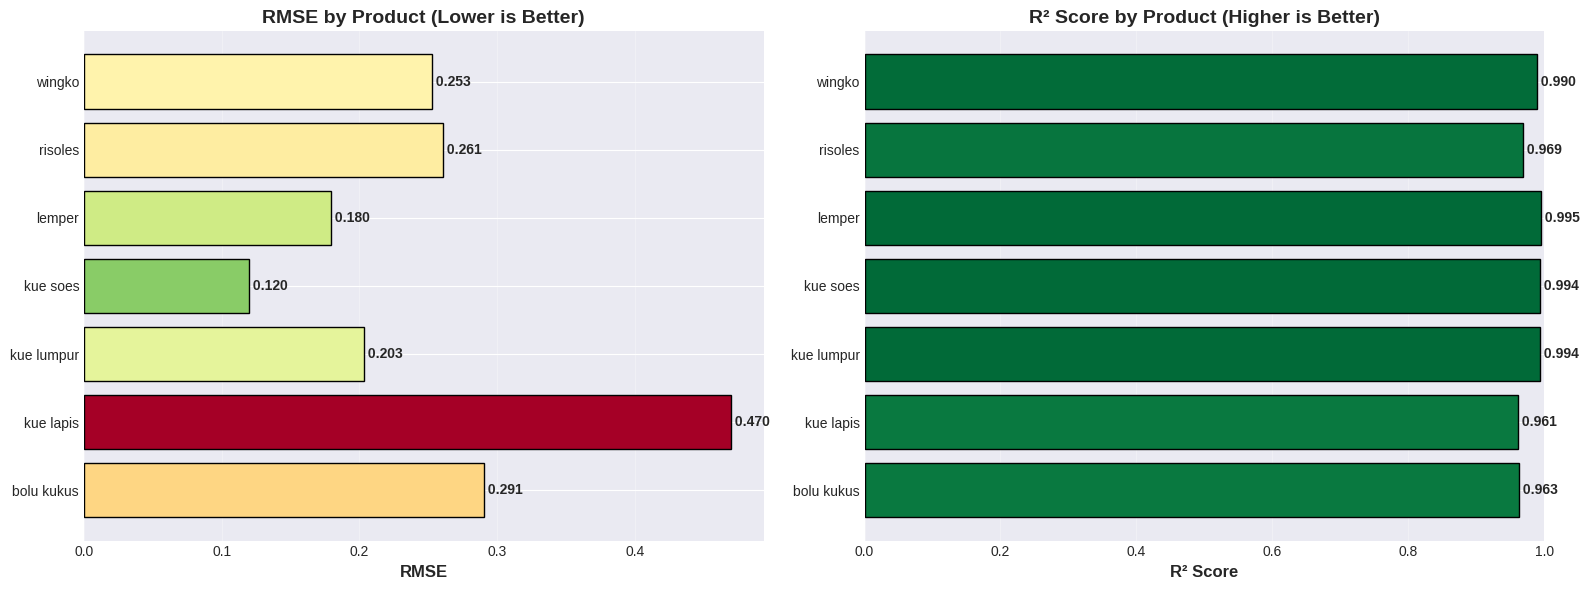

✓ Saved: product_performance.png


In [66]:
# Plot 5: Product-Level Performance
print("\nGenerating product-level performance plot...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE by Product
product_names = product_results_df['Product'].values
product_rmse = product_results_df['RMSE'].values
colors_rmse = plt.cm.RdYlGn_r(product_rmse / product_rmse.max())
axes[0].barh(product_names, product_rmse, color=colors_rmse, edgecolor='black', linewidth=1)
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('RMSE by Product (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(product_rmse):
    axes[0].text(v, i, f' {v:.3f}', va='center', fontsize=10, fontweight='bold')

# R² by Product
product_r2 = product_results_df['R²'].values
colors_r2 = plt.cm.RdYlGn(product_r2)
axes[1].barh(product_names, product_r2, color=colors_r2, edgecolor='black', linewidth=1)
axes[1].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('R² Score by Product (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(product_r2):
    axes[1].text(v, i, f' {v:.3f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('product_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: product_performance.png")



Generating error distribution by product...


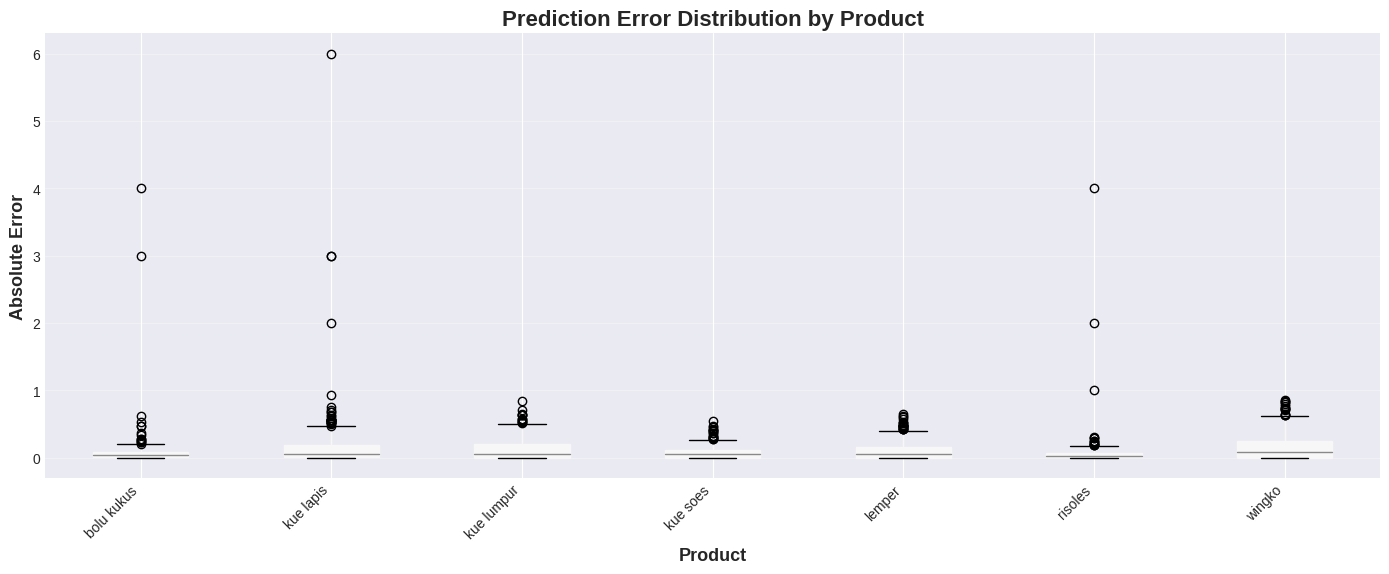

✓ Saved: error_by_product_boxplot.png


In [67]:
# Plot 6: Error Distribution by Product
print("\nGenerating error distribution by product...")
error_by_product_df = pd.DataFrame({
    'Product': test_products,
    'Error': errors
})

fig, ax = plt.subplots(figsize=(14, 6))
error_by_product_df.boxplot(column='Error', by='Product', ax=ax, patch_artist=True)
plt.suptitle('')
ax.set_title('Prediction Error Distribution by Product', fontsize=16, fontweight='bold')
ax.set_xlabel('Product', fontsize=13, fontweight='bold')
ax.set_ylabel('Absolute Error', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('error_by_product_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: error_by_product_boxplot.png")


Generating day of week performance plot...


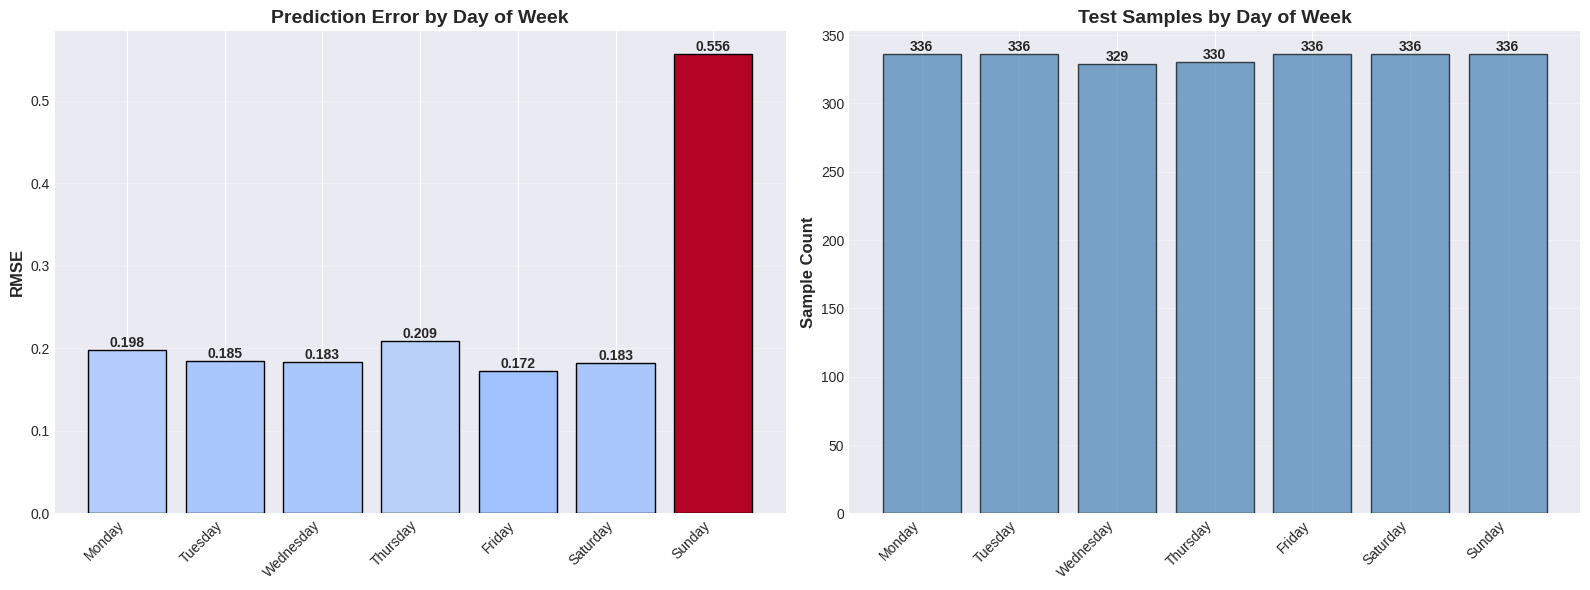

✓ Saved: day_of_week_performance.png


In [68]:
# Plot 7: Day of Week Performance
print("\nGenerating day of week performance plot...")
dow_performance = []
for dow in range(7):
    dow_mask = test_dow == dow
    if dow_mask.sum() > 0:
        dow_actual = y_test.values[dow_mask]
        dow_pred = y_test_pred_corrected[dow_mask]
        dow_rmse = np.sqrt(mean_squared_error(dow_actual, dow_pred))
        dow_performance.append({'Day': dow_names[dow], 'RMSE': dow_rmse, 'Count': dow_mask.sum()})

dow_df = pd.DataFrame(dow_performance)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE by Day
colors_dow = plt.cm.coolwarm(dow_df['RMSE'].values / dow_df['RMSE'].max())
axes[0].bar(dow_df['Day'], dow_df['RMSE'], color=colors_dow, edgecolor='black', linewidth=1)
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Prediction Error by Day of Week', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, (day, rmse) in enumerate(zip(dow_df['Day'], dow_df['RMSE'])):
    axes[0].text(i, rmse, f'{rmse:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Sample Count by Day
axes[1].bar(dow_df['Day'], dow_df['Count'], color='steelblue', edgecolor='black', linewidth=1, alpha=0.7)
axes[1].set_ylabel('Sample Count', fontsize=12, fontweight='bold')
axes[1].set_title('Test Samples by Day of Week', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, (day, count) in enumerate(zip(dow_df['Day'], dow_df['Count'])):
    axes[1].text(i, count, f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('day_of_week_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: day_of_week_performance.png")


Generating temporal performance plot...


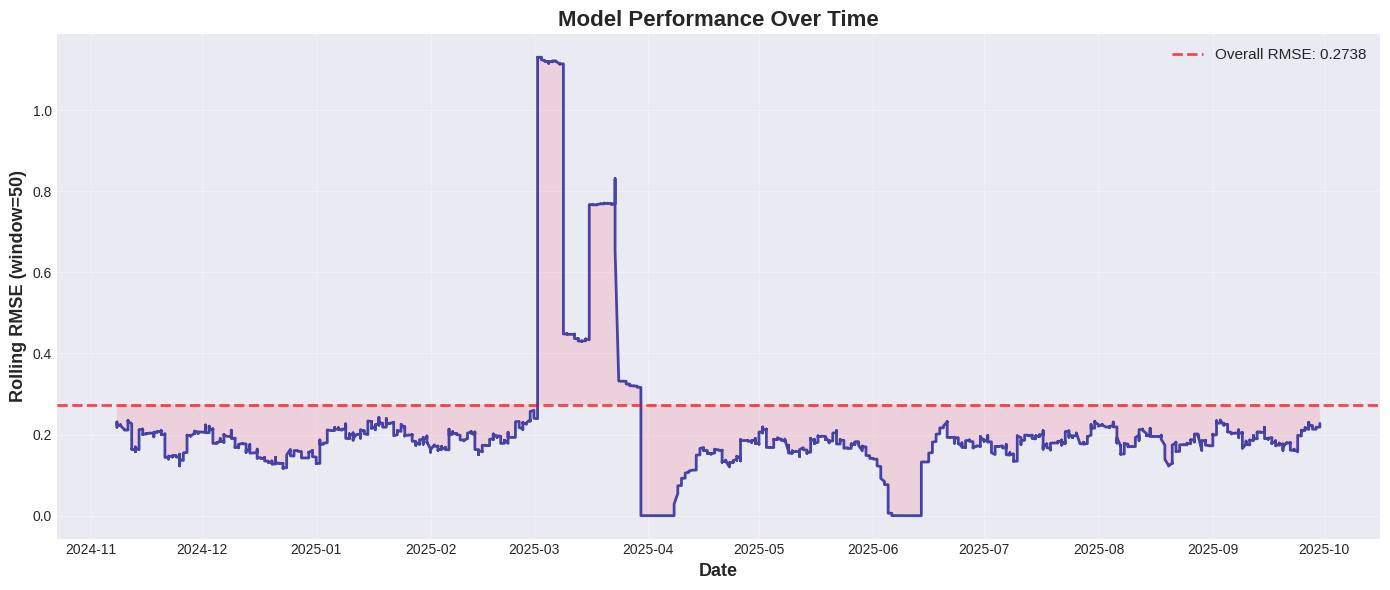

✓ Saved: temporal_performance.png


In [69]:
# Plot 8: Temporal Performance Over Test Period
print("\nGenerating temporal performance plot...")
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate rolling RMSE over test period
window_size = 50  # 50-sample rolling window
rolling_rmse = []
for i in range(len(y_test) - window_size):
    window_actual = y_test.values[i:i+window_size]
    window_pred = y_test_pred_corrected[i:i+window_size]
    window_rmse = np.sqrt(mean_squared_error(window_actual, window_pred))
    rolling_rmse.append(window_rmse)

# rolling_dates = test_dates[window_size//2:-window_size//2+1]
rolling_dates = test_dates[window_size:window_size+len(rolling_rmse)]
ax.plot(rolling_dates, rolling_rmse, linewidth=2, color='darkblue', alpha=0.7)
ax.axhline(y=test_rmse, color='red', linestyle='--', linewidth=2, label=f'Overall RMSE: {test_rmse:.4f}', alpha=0.7)
ax.fill_between(rolling_dates, rolling_rmse, test_rmse, alpha=0.2)
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel(f'Rolling RMSE (window={window_size})', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Over Time', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('temporal_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: temporal_performance.png")


Generating prediction interval plot...


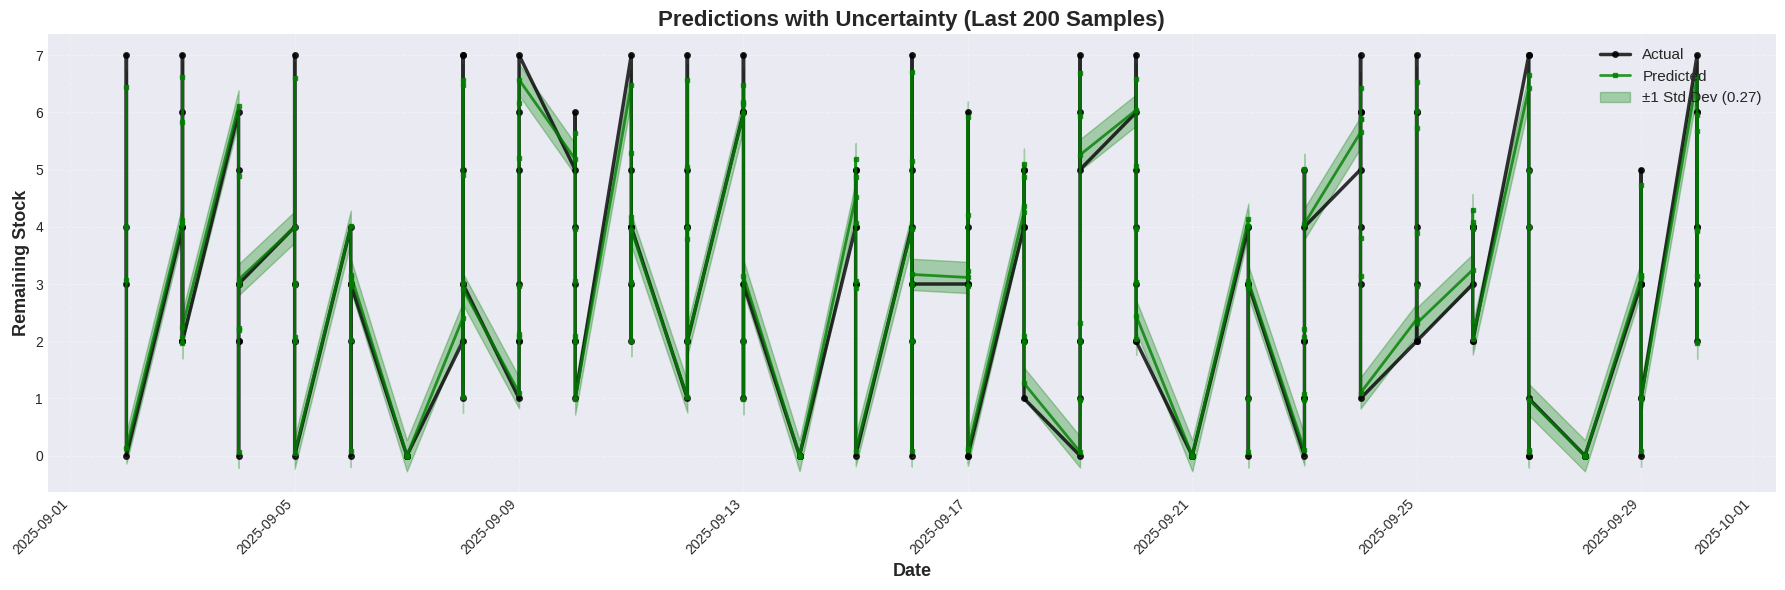

✓ Saved: prediction_intervals.png

✅ All visualizations generated successfully!


In [70]:
# Plot 9: Prediction Intervals (Uncertainty Visualization)
print("\nGenerating prediction interval plot...")
# Use standard deviation of residuals as uncertainty measure
uncertainty = residuals.std()

fig, ax = plt.subplots(figsize=(18, 6))
# Plot sample of predictions (last 200 for clarity)
sample_size = 200
sample_dates = test_dates[-sample_size:]
sample_actual = y_test.values[-sample_size:]
sample_pred = y_test_pred_corrected[-sample_size:]

ax.plot(sample_dates, sample_actual, label='Actual', linewidth=2.5, alpha=0.8, color='black', marker='o', markersize=4)
ax.plot(sample_dates, sample_pred, label='Predicted', linewidth=2, alpha=0.8, color='green', marker='s', markersize=3)
ax.fill_between(sample_dates, sample_pred - uncertainty, sample_pred + uncertainty, 
                alpha=0.3, color='green', label=f'±1 Std Dev ({uncertainty:.2f})')
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Remaining Stock', fontsize=13, fontweight='bold')
ax.set_title(f'Predictions with Uncertainty (Last {sample_size} Samples)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('prediction_intervals.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: prediction_intervals.png")

print("\n✅ All visualizations generated successfully!")

In [71]:
# ============================================================================
# 10. SAVE COMPREHENSIVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("💾 SAVING COMPREHENSIVE RESULTS")
print("="*80)

# Save detailed predictions
results_df = pd.DataFrame({
    'date': test_dates,
    'product': test_products,
    'day_of_week': [dow_names[d] for d in test_dow],
    'is_sunday': test_is_sunday,
    'actual': y_test.values,
    'predicted_raw': y_test_pred,
    'predicted_corrected': y_test_pred_corrected,
    'error': y_test.values - y_test_pred_corrected,
    'absolute_error': errors,
    'squared_error': (y_test.values - y_test_pred_corrected) ** 2
})

results_df.to_csv('predictions_detailed.csv', index=False)
print("✓ Saved: predictions_detailed.csv")

# Save feature importance
feature_importance.to_csv('feature_importance_full.csv', index=False)
print("✓ Saved: feature_importance_full.csv")

# Save product-level performance
product_results_df.to_csv('product_performance_metrics.csv', index=False)
print("✓ Saved: product_performance_metrics.csv")

# Save day-of-week performance
dow_df.to_csv('day_of_week_performance.csv', index=False)
print("✓ Saved: day_of_week_performance.csv")

# Save comprehensive metrics
comprehensive_metrics = {
    'Overall Performance': {
        'Train RMSE': train_rmse,
        'Test RMSE (Raw)': test_rmse_raw,
        'Test RMSE (Final)': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Overfitting %': overfitting_pct,
        'CV Mean RMSE': cv_rmse.mean(),
        'CV Std RMSE': cv_rmse.std()
    },
    'Error Distribution': {
        'Mean Error': errors.mean(),
        'Median Error': np.median(errors),
        'Std Error': errors.std(),
        'Min Error': errors.min(),
        'Max Error': errors.max(),
        '95th Percentile Error': np.percentile(errors, 95),
        '99th Percentile Error': np.percentile(errors, 99)
    },
    'Error Buckets': {
        'Errors ≤ 0.5': f"{error_0_5} ({error_0_5/total*100:.1f}%)",
        'Errors 0.5-1.0': f"{error_0_5_1} ({error_0_5_1/total*100:.1f}%)",
        'Errors 1.0-2.0': f"{error_1_2} ({error_1_2/total*100:.1f}%)",
        'Errors 2.0-3.0': f"{error_2_3} ({error_2_3/total*100:.1f}%)",
        'Errors > 3.0': f"{error_3_plus} ({error_3_plus/total*100:.1f}%)"
    },
    'Sunday Analysis': {
        'Total Sundays': int(sunday_mask.sum()),
        'Actual Zeros': int((sunday_actual == 0).sum()),
        'Predicted Zeros': int((sunday_pred == 0).sum()),
        'Sunday RMSE': float(np.sqrt(mean_squared_error(sunday_actual, sunday_pred)))
    },
    'Weekday Analysis': {
        'Total Weekdays': int(non_sunday_mask.sum()),
        'Weekday RMSE': float(np.sqrt(mean_squared_error(non_sunday_actual, non_sunday_pred))),
        'Weekday R²': float(r2_score(non_sunday_actual, non_sunday_pred))
    },
    'Zero Predictions': {
        'Actual Zeros': int(actual_zeros),
        'Predicted Zeros': int(predicted_zeros),
        'Correct Zero Predictions': int(correct_zero_predictions),
        'False Zeros': int(false_zeros),
        'Missed Zeros': int(missed_zeros),
        'Zero Recall %': float(zero_recall) if actual_zeros > 0 else 0
    },
    'Best/Worst Products': {
        'Best Product': best_product,
        'Best Product RMSE': float(product_results_df.loc[product_results_df['Product'] == best_product, 'RMSE'].values[0]),
        'Worst Product': worst_product,
        'Worst Product RMSE': float(product_results_df.loc[product_results_df['Product'] == worst_product, 'RMSE'].values[0])
    }
}

import json
with open('comprehensive_metrics.json', 'w') as f:
    json.dump(comprehensive_metrics, f, indent=4)
print("✓ Saved: comprehensive_metrics.json")

# Save model and encoders
import joblib
joblib.dump(model, 'model_no_leakage.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print("✓ Saved: model_no_leakage.pkl")
print("✓ Saved: label_encoders.pkl")

# Create summary report
print("\n📄 Creating Summary Report...")
with open('model_evaluation_report.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("RANDOM FOREST TIME SERIES FORECASTING - EVALUATION REPORT\n")
    f.write("LEAKAGE-FREE MODEL\n")
    f.write("="*80 + "\n\n")
    
    f.write("1. OVERALL PERFORMANCE\n")
    f.write("-" * 60 + "\n")
    f.write(f"Train RMSE: {train_rmse:.4f}\n")
    f.write(f"Test RMSE:  {test_rmse:.4f}\n")
    f.write(f"Train R²:   {train_r2:.4f}\n")
    f.write(f"Test R²:    {test_r2:.4f}\n")
    f.write(f"Overfitting Gap: {abs(overfitting_pct):.2f}%\n\n")
    
    f.write("2. CROSS-VALIDATION RESULTS\n")
    f.write("-" * 60 + "\n")
    f.write(f"Mean CV RMSE: {cv_rmse.mean():.4f} (± {cv_rmse.std():.4f})\n")
    for i, score in enumerate(cv_rmse, 1):
        f.write(f"  Fold {i}: {score:.4f}\n")
    f.write("\n")
    
    f.write("3. ERROR DISTRIBUTION\n")
    f.write("-" * 60 + "\n")
    f.write(f"Mean Error:   {errors.mean():.4f}\n")
    f.write(f"Median Error: {np.median(errors):.4f}\n")
    f.write(f"Std Error:    {errors.std():.4f}\n")
    f.write(f"Max Error:    {errors.max():.4f}\n\n")
    f.write(f"Errors ≤ 0.5:   {error_0_5} ({error_0_5/total*100:.1f}%)\n")
    f.write(f"Errors 0.5-1.0: {error_0_5_1} ({error_0_5_1/total*100:.1f}%)\n")
    f.write(f"Errors 1.0-2.0: {error_1_2} ({error_1_2/total*100:.1f}%)\n")
    f.write(f"Errors 2.0-3.0: {error_2_3} ({error_2_3/total*100:.1f}%)\n")
    f.write(f"Errors > 3.0:   {error_3_plus} ({error_3_plus/total*100:.1f}%)\n\n")
    
    f.write("4. PRODUCT-LEVEL PERFORMANCE\n")
    f.write("-" * 60 + "\n")
    for _, row in product_results_df.iterrows():
        f.write(f"{row['Product']:<15} RMSE: {row['RMSE']:.4f} | R²: {row['R²']:.4f}\n")
    f.write("\n")
    
    f.write("5. DAY-OF-WEEK PERFORMANCE\n")
    f.write("-" * 60 + "\n")
    for _, row in dow_df.iterrows():
        f.write(f"{row['Day']:<12} RMSE: {row['RMSE']:.4f}\n")
    f.write("\n")
    
    f.write("6. TOP 15 FEATURES\n")
    f.write("-" * 60 + "\n")
    for idx, row in feature_importance.head(15).iterrows():
        f.write(f"{row['feature']:<40} {row['importance']:.4f}\n")
    f.write("\n")
    
    f.write("7. RECOMMENDATIONS\n")
    f.write("-" * 60 + "\n")
    if test_r2 > 0.95:
        f.write("✅ Excellent model performance! Ready for deployment.\n")
    elif test_r2 > 0.90:
        f.write("✅ Good model performance. Consider fine-tuning for improvement.\n")
    else:
        f.write("⚠️ Model needs improvement. Consider additional features or different approach.\n")
    
    if abs(overfitting_pct) < 10:
        f.write("✅ Minimal overfitting detected.\n")
    elif abs(overfitting_pct) < 20:
        f.write("⚠️ Moderate overfitting. Consider regularization.\n")
    else:
        f.write("❌ High overfitting. Increase regularization or reduce model complexity.\n")
    
    f.write("\n")
    f.write("="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

print(" Saved: model_evaluation_report.txt")


💾 SAVING COMPREHENSIVE RESULTS
✓ Saved: predictions_detailed.csv
✓ Saved: feature_importance_full.csv
✓ Saved: product_performance_metrics.csv
✓ Saved: day_of_week_performance.csv
✓ Saved: comprehensive_metrics.json
✓ Saved: model_no_leakage.pkl
✓ Saved: label_encoders.pkl

📄 Creating Summary Report...
 Saved: model_evaluation_report.txt
